# Prepare samples for DeepLabV3

A routine for preparation of samples for DeepLabv3 segmentation. The samples are prepared form DEM rasters and vector mask.


This notebook will show the routine on the example of "terase" (terraces).

In [57]:
import rasterio
import numpy as np
import geopandas as gpd
from pyproj import CRS
import time
from shapely.geometry import box, mapping
%matplotlib inline

First, let's define some functions:

- `uniform_grid` creates a GeoDataFrame with uniform grid cells, which represent all the possible samples (tiles) that cover our region
- `get_vrt_extents` returns metadata of vrt file (virtual raster format)

In [2]:
# Create mesh
def uniform_grid(extents, spacing=256, epsg=3794):
    print("Creating uniform grid...")

    # total area for the grid [xmin, ymin, xmax, ymax]
    # extents = [378086.9099999999743886, 31798.7700000000004366, 615456.9200000000419095, 193207.6099999999860302]
    x_min, y_min, x_max, y_max = extents  # gdf.total_bounds

    # projection of the grid
    crs = CRS.from_epsg(epsg).to_wkt()

    grid_cells = []
    for x0 in np.arange(x_min, x_max, spacing):
        for y0 in np.arange(y_max, y_min, -spacing):
            # bounds
            x1 = x0 + spacing
            y1 = y0 - spacing
            grid_cells.append(box(x0, y0, x1, y1))

    # save as dataframe
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    grid['cell_id'] = range(1, len(grid) + 1)

    return grid


def get_vrt_extents(path):
    # Read metadata from raster
    with rasterio.open(path, "r") as src:
        # Pixel size
        pix_size = src.profile["transform"].a
        width = src.profile["width"]
        height = src.profile["height"]
        x_min = src.profile["transform"].c
        y_max = src.profile["transform"].f
        x_max = x_min + width * pix_size
        y_min = y_max - height * pix_size
        vrt = {
            "spacing": tile_size * pix_size,
            "extents": [x_min, y_min, x_max, y_max],
            "pixel_size": pix_size
        }
    return vrt

Set some input parameters

In [3]:
# Path to DEM mosaic (vrt)
vrt_path = "..\\test_data\\DEM_D96_05m_virtual_mosaic.vrt"

# Path to mask (shp)
terase_pth = "..\\test_data\\terase_svn_d96.shp"

# Size of a square tile in pixels
tile_size = 512

# CRS for saving the grid
crs = CRS.from_epsg(3794)

The raster is read from a vrt file (a Virtual Raster Format).

In [4]:
%%time
# Get raster meta data
raster_meta = get_vrt_extents(vrt_path)

Wall time: 998 ms


Now we also need to read the vector layer (terase mask). In our example, the vector data is presented as one large feature (multypolygon). This format is favourable, because it makes the selection of valid tiles (samples in the grid) more simple... no need for removal of duplicats in the later stages. However, if for some reason one would requier multiple single polygons, then use method gdf.explode() on the GeoDataFrame.

Wall time: 4.36 s


<AxesSubplot:>

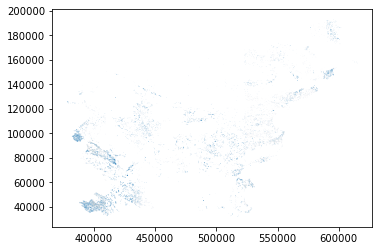

In [5]:
%%time
# Read polygon that will be used for masking & find extents
terase = gpd.read_file(terase_pth)

# Explode into multiple single features:
# terase = terase.explode()

# Plot the shapefile
terase.plot()

Select the minimu bounding box of both sources (vrt and polygon).

In [6]:
%%time

# Define grid extents (minimum area covered by both raster and polygons)
r_ext = raster_meta["extents"]
s_ext = list(terase.bounds.iloc[0])
g_ext = [
    np.floor(max(r_ext[0], s_ext[0])),
    np.floor(max(r_ext[1], s_ext[1])),
    np.ceil(min(r_ext[2], s_ext[2])),
    np.ceil(min(r_ext[3], s_ext[3]))
]

Wall time: 17 ms


Now create grid using the function we defined at the top

In [7]:
%%time

# Create grid from extents
tile_width = int(raster_meta["spacing"])  # Spacing comes out as float, but we need int (spacing = number of pixels)
all_tiles = uniform_grid(g_ext, tile_width, crs.to_epsg())

Creating uniform grid...
Wall time: 8.42 s


Let's see how many potential samples there are.

In [8]:
all_tiles.shape

# optionally save to shappe file
# all_tiles.to_file("..\\all_tiles_2048")

(585568, 2)

However, not all of these are covered by our validity mask. Now we need to filter our data frame to retain only tiles that contain our samples. We will look for all grid cells that intersect with the polygon mask. Because of a large number of cells, we will use spatial indexing to speed up the search process.

We can use the `.sindex` method to create the spatial index and `.querry()` with attribute `predicate="intersects"`

NOTE: We use `query_bulk` (instead of `query`) because the terase polygon is in GDS (GeoDataSeries) format. I have left it like this, so it will be more flexible for future use, as it will be able to use vector layers with both, one multipolygon and multiple single polygons. There is minimal impact on the preformance as can be seen below. Also, if using `query` the queried polygon has to be in shapely format (not GDS)

In [10]:
%%time

my_grid = all_tiles.geometry.sindex.query_bulk(terase.geometry, predicate="intersects")

Wall time: 2min 17s


In [13]:
%%time

my_grid2 = all_tiles.geometry.sindex.query(terase.geometry[0], predicate="intersects")

Wall time: 2min 9s


The resulting array `my_grid` contains a list of indices of tiles containing our samples. Now all we need to do is select rows from the list of indices.

In [32]:
needed_tiles = all_tiles.iloc[list(np.sort(my_grid[1, :]))].copy()

# Add sample_id
needed_tiles['sample_id'] = range(1, len(needed_tiles) + 1)

# Reset index
needed_tiles.reset_index(inplace = True, drop=True)

needed_tiles

,geometry,cell_id,sample_id
0,"POLYGON ((378342.000 126392.000, 378342.000 12...",262,1
1,"POLYGON ((378342.000 126136.000, 378342.000 12...",263,2
2,"POLYGON ((378342.000 125880.000, 378342.000 12...",264,3
3,"POLYGON ((378598.000 126392.000, 378598.000 12...",893,4
4,"POLYGON ((378598.000 126136.000, 378598.000 12...",894,5
...,...,...,...
29327,"POLYGON ((615142.000 158136.000, 615142.000 15...",583813,29328
29328,"POLYGON ((615398.000 158136.000, 615398.000 15...",584444,29329
29329,"POLYGON ((615398.000 157368.000, 615398.000 15...",584447,29330
29330,"POLYGON ((615654.000 157368.000, 615654.000 15...",585078,29331


<AxesSubplot:>

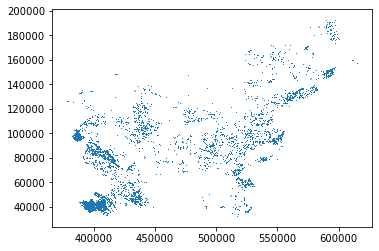

In [21]:
# Todo: Plot "terase" overlaid on top of grid, and zoom in on a smaller region

needed_tiles.plot()

## Selecting random samples

In [34]:
random_tiles = needed_tiles.sample(frac=1).reset_index(drop=True)

random_tiles

,geometry,cell_id,sample_id
0,"POLYGON ((431590.000 53688.000, 431590.000 534...",131794,10552
1,"POLYGON ((418278.000 52408.000, 418278.000 521...",98987,8631
2,"POLYGON ((591590.000 182968.000, 591590.000 18...",525664,28453
3,"POLYGON ((543206.000 103096.000, 543206.000 10...",406717,24191
4,"POLYGON ((506086.000 111800.000, 506086.000 11...",315188,17780
...,...,...,...
29327,"POLYGON ((445158.000 104888.000, 445158.000 10...",165037,13757
29328,"POLYGON ((524518.000 36536.000, 524518.000 362...",360914,20736
29329,"POLYGON ((423910.000 57784.000, 423910.000 575...",112848,9331
29330,"POLYGON ((506342.000 92600.000, 506342.000 923...",315894,17815


<AxesSubplot:>

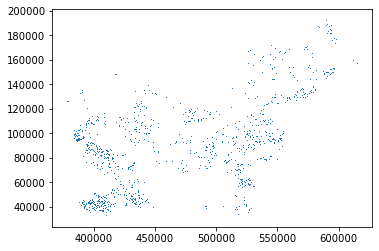

In [39]:
no_randoms = 10000

random_tiles[:no_randoms].plot()

In [53]:
import tqdm
from rasterio.mask import mask

In [54]:
def ms_rio(geom, raster):
    """Returns subset of an array covered by the input polygon. The input
    polygon has to be in the GeoJSON format. The crop attribute sets values
    not covered by polygon to nan. All_touched is used to prevent empty rasters
    for very thin polygons."""
    out_image, _ = mask(raster, geom, crop=True, all_touched=True, nodata=np.nan)
    return out_image

In [56]:
%%time

tdf = random_tiles[:1000].copy()

Wall time: 25.9 ms


In [59]:
%%time

tdf["geom"] = tdf.geometry.apply(lambda g: [mapping(g)])

Wall time: 57.8 ms


In [61]:
tdf.head()

,geometry,cell_id,sample_id,geom
0,"POLYGON ((431590.000 53688.000, 431590.000 534...",131794,10552,"[{'type': 'Polygon', 'coordinates': (((431590...."
1,"POLYGON ((418278.000 52408.000, 418278.000 521...",98987,8631,"[{'type': 'Polygon', 'coordinates': (((418278...."
2,"POLYGON ((591590.000 182968.000, 591590.000 18...",525664,28453,"[{'type': 'Polygon', 'coordinates': (((591590...."
3,"POLYGON ((543206.000 103096.000, 543206.000 10...",406717,24191,"[{'type': 'Polygon', 'coordinates': (((543206...."
4,"POLYGON ((506086.000 111800.000, 506086.000 11...",315188,17780,"[{'type': 'Polygon', 'coordinates': (((506086...."


In [63]:
%%time

src = rasterio.open(vrt_path)
tdf["hand_rst"] = tdf.geom.apply(lambda g: ms_rio(g, src))
src.close()

# resitev... skopiraj vse podatke na D in tam zazeni jupyter notebook
# prepisi tole v PyCharm in zazeni,
# Potem bo potrebno dodati samo se rvt vizualizacijo

# Vprašaj Žigata kje on piše Python kodo, Pycharm je zelo annoying!!!!!!

RasterioIOError: Read or write failed. l:\Slovenija\DEM_D96_05m_buffered\tile_431000_53000_dem_05m_buffered.tif: No such file or directory